<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/kmedoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --force-reinstall numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have n

In [2]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import time
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder


In [2]:

def print_metrics(X, true_labels_values, predicted_labels):
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")


In [3]:
seed = 0

In [16]:
def k_medoids(X, k, max_iter=100, tol=1e-4, metric='euclidean', method="pam"):
    n = len(X)
    rng = np.random.default_rng(seed)
    medoid_indices = rng.choice(n, k, replace=False)
    medoids = X[medoid_indices]
    prev_medoids = np.zeros_like(medoids)
    labels = np.zeros(n, dtype=int)

    for _ in range(max_iter):
        # Assign each point to the nearest medoid
        distances = cdist(X, medoids, metric)
        labels = np.argmin(distances, axis=1)

        # Swap step: Try replacing medoids with non-medoids and check cost
        for i, medoid in enumerate(medoids):
            cluster_points = X[labels == i]
            best_medoid = medoid
            best_cost = np.sum(cdist(cluster_points, [medoid], metric))

            for point in cluster_points:
                cost = np.sum(cdist(cluster_points, [point], metric))
                if cost < best_cost:
                    best_medoid = point
                    best_cost = cost

            medoids[i] = best_medoid

        # Convergence check
        if np.allclose(prev_medoids, medoids, atol=tol):
            break
        prev_medoids = medoids.copy()

    return labels, medoids

In [17]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()
k_iris = 3

print("Iris Dataset\n")

start_time = time.time()
labels_base_iris, centroids_base_iris = k_medoids(X_iris, k_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_iris, iris["species"], labels_base_iris)

start_time = time.time()
kmedoids_iris = KMedoids(n_clusters=k_iris, random_state=seed).fit(X_iris)
labels_sklearn_iris = kmedoids_iris.labels_
centroids_sklearn_iris = kmedoids_iris.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris["species"], labels_sklearn_iris)

Iris Dataset

Execution time (base): 0.01213836669921875 seconds
-------------------------------------------------------------------
Silhouette score: 0.5526
Adjusted Rand score: 0.7302
Calinski-Harabasz score: 560.3999
Davies-Bouldin score: 0.6623
Mutual Information score: 0.8256

Execution time (sklearn): 0.004186153411865234 seconds
-------------------------------------------------------------------
Silhouette score: 0.5200
Adjusted Rand score: 0.7583
Calinski-Harabasz score: 520.4530
Davies-Bouldin score: 0.6690
Mutual Information score: 0.8555


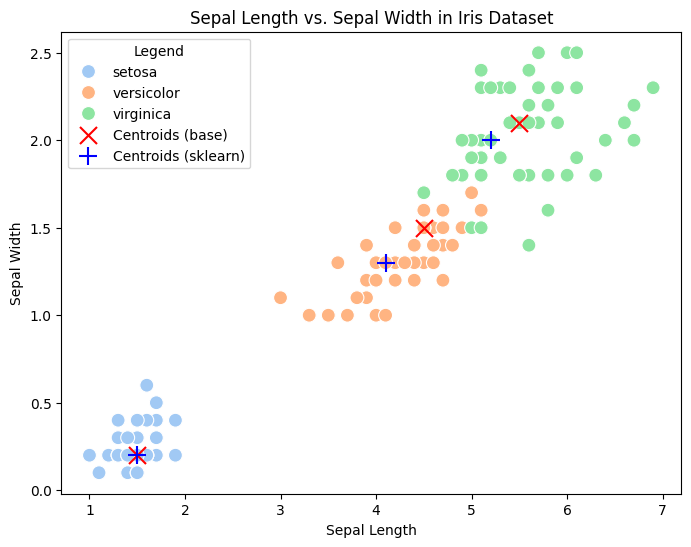

In [18]:
plength_idx = list(iris_filtered.columns).index("petal_length")
pwidth_idx = list(iris_filtered.columns).index("petal_width")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette="pastel", s=100)
plt.scatter(centroids_base_iris[:, plength_idx], centroids_base_iris[:, pwidth_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_iris[:, plength_idx], centroids_sklearn_iris[:, pwidth_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Sepal Length vs. Sepal Width in Iris Dataset")
plt.legend(title="Legend")
plt.show()

In [19]:
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()
k_ai = 3

print("AI Global Index")

start_time = time.time()
labels_base_ai, centroids_base_ai = k_medoids(X_ai, k_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_ai, ai["Total_score_Category"], labels_base_ai)

start_time = time.time()
k_medoids_ai = KMedoids(n_clusters=k_ai, random_state=seed).fit(X_ai)
labels_sklearn_ai = k_medoids_ai.labels_
centroids_sklearn_ai = k_medoids_ai.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai["Total_score_Category"], labels_sklearn_ai)

AI Global Index
Execution time (base): 0.008550643920898438 seconds
-------------------------------------------------------------------
Silhouette score: 0.2379
Adjusted Rand score: 0.3969
Calinski-Harabasz score: 24.0062
Davies-Bouldin score: 1.3054
Mutual Information score: 0.4969

Execution time (sklearn): 0.002867460250854492 seconds
-------------------------------------------------------------------
Silhouette score: 0.1267
Adjusted Rand score: 0.2952
Calinski-Harabasz score: 15.7131
Davies-Bouldin score: 1.8911
Mutual Information score: 0.3786


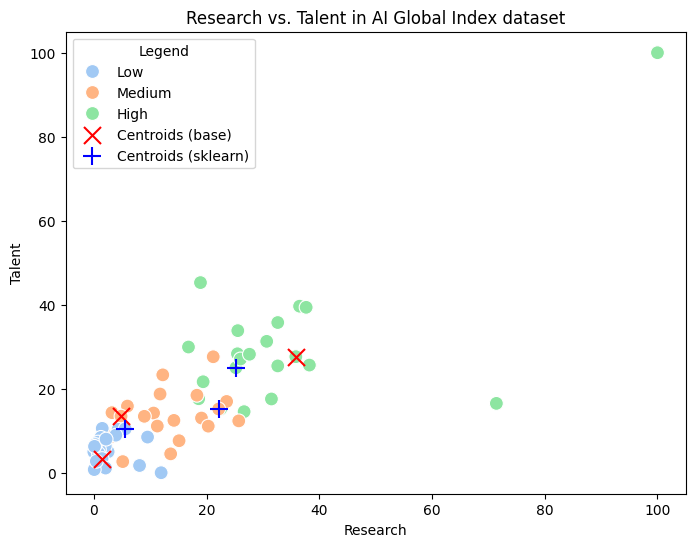

In [20]:
research_idx = list(ai_filtered.columns).index("Research")
talent_idx = list(ai_filtered.columns).index("Talent")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="pastel", s=100)
plt.scatter(centroids_base_ai[:, research_idx], centroids_base_ai[:, talent_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_ai[:, research_idx], centroids_sklearn_ai[:, talent_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Research")
plt.ylabel("Talent")
plt.title("Research vs. Talent in AI Global Index dataset")
plt.legend(title="Legend")
plt.show()

In [21]:
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_medoids(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_base_earth)

start_time = time.time()
kmedoids_earth = KMedoids(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmedoids_earth.labels_
centroids_sklearn_earth = kmedoids_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_sklearn_earth)

Global Earthquake Data
Execution time (base): 0.10390257835388184 seconds
-------------------------------------------------------------------
Silhouette score: -0.0467
Adjusted Rand score: -0.0079
Calinski-Harabasz score: 3.3666
Davies-Bouldin score: 1.8054
Mutual Information score: 0.0755

Execution time (sklearn): 0.04385781288146973 seconds
-------------------------------------------------------------------
Silhouette score: 0.1187
Adjusted Rand score: -0.0300
Calinski-Harabasz score: 48.0067
Davies-Bouldin score: 1.5994
Mutual Information score: 0.0568


/usr/local/lib/python3.11/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


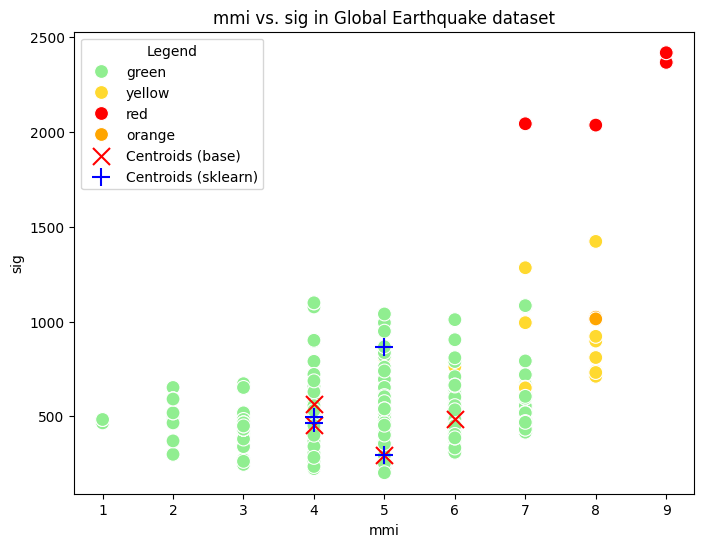

In [22]:
sig_idx = list(earthquakes_filtered.columns).index("sig")
mmi_idx = list(earthquakes_filtered.columns).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, sig_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, sig_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("sig")
plt.title("mmi vs. sig in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [23]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

encoder = OrdinalEncoder()

alert_encoded = encoder.fit_transform(earthquakes["alert"].to_frame())
selector = SelectKBest(score_func=mutual_info_classif, k=5)

X_earth = selector.fit_transform(earthquakes_filtered, alert_encoded.ravel())
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_medoids(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_base_earth)

start_time = time.time()
kmedoids_earth = KMedoids(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmedoids_earth.labels_
centroids_sklearn_earth = kmedoids_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_sklearn_earth)

Global Earthquake Data
Execution time (base): 0.19960880279541016 seconds
-------------------------------------------------------------------
Silhouette score: 0.4156
Adjusted Rand score: 0.0740
Calinski-Harabasz score: 468.9790
Davies-Bouldin score: 0.7949
Mutual Information score: 0.1193

Execution time (sklearn): 0.036083221435546875 seconds
-------------------------------------------------------------------
Silhouette score: 0.4156
Adjusted Rand score: 0.0740
Calinski-Harabasz score: 468.9790
Davies-Bouldin score: 0.7949
Mutual Information score: 0.1193


/usr/local/lib/python3.11/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


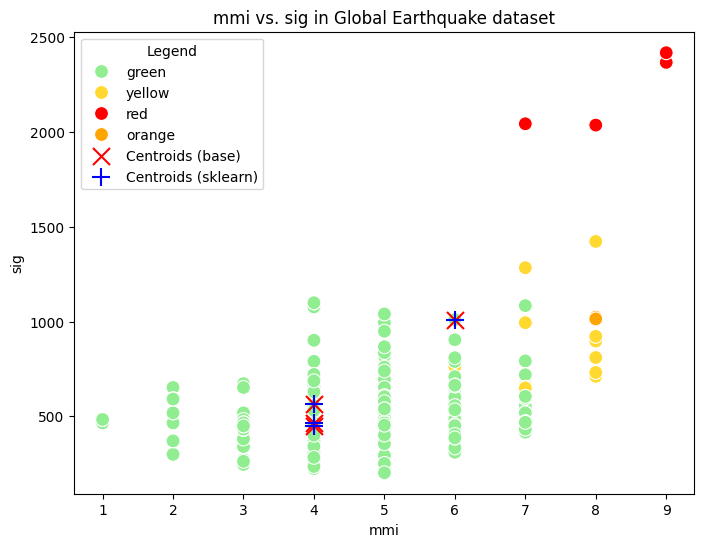

In [24]:
sig_idx = list(earthquakes_filtered.columns[selector.get_support()]).index("sig")
mmi_idx = list(earthquakes_filtered.columns[selector.get_support()]).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, sig_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, sig_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("sig")
plt.title("mmi vs. sig in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [25]:
scores = selector.scores_
feature_ranking = sorted(zip(earthquakes_filtered.columns, scores), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in feature_ranking[:5]]
print("Top 5 Features Sorted by Importance:", top_features)

Top 5 Features Sorted by Importance: ['sig', 'mmi', 'longitude', 'latitude', 'magnitude']


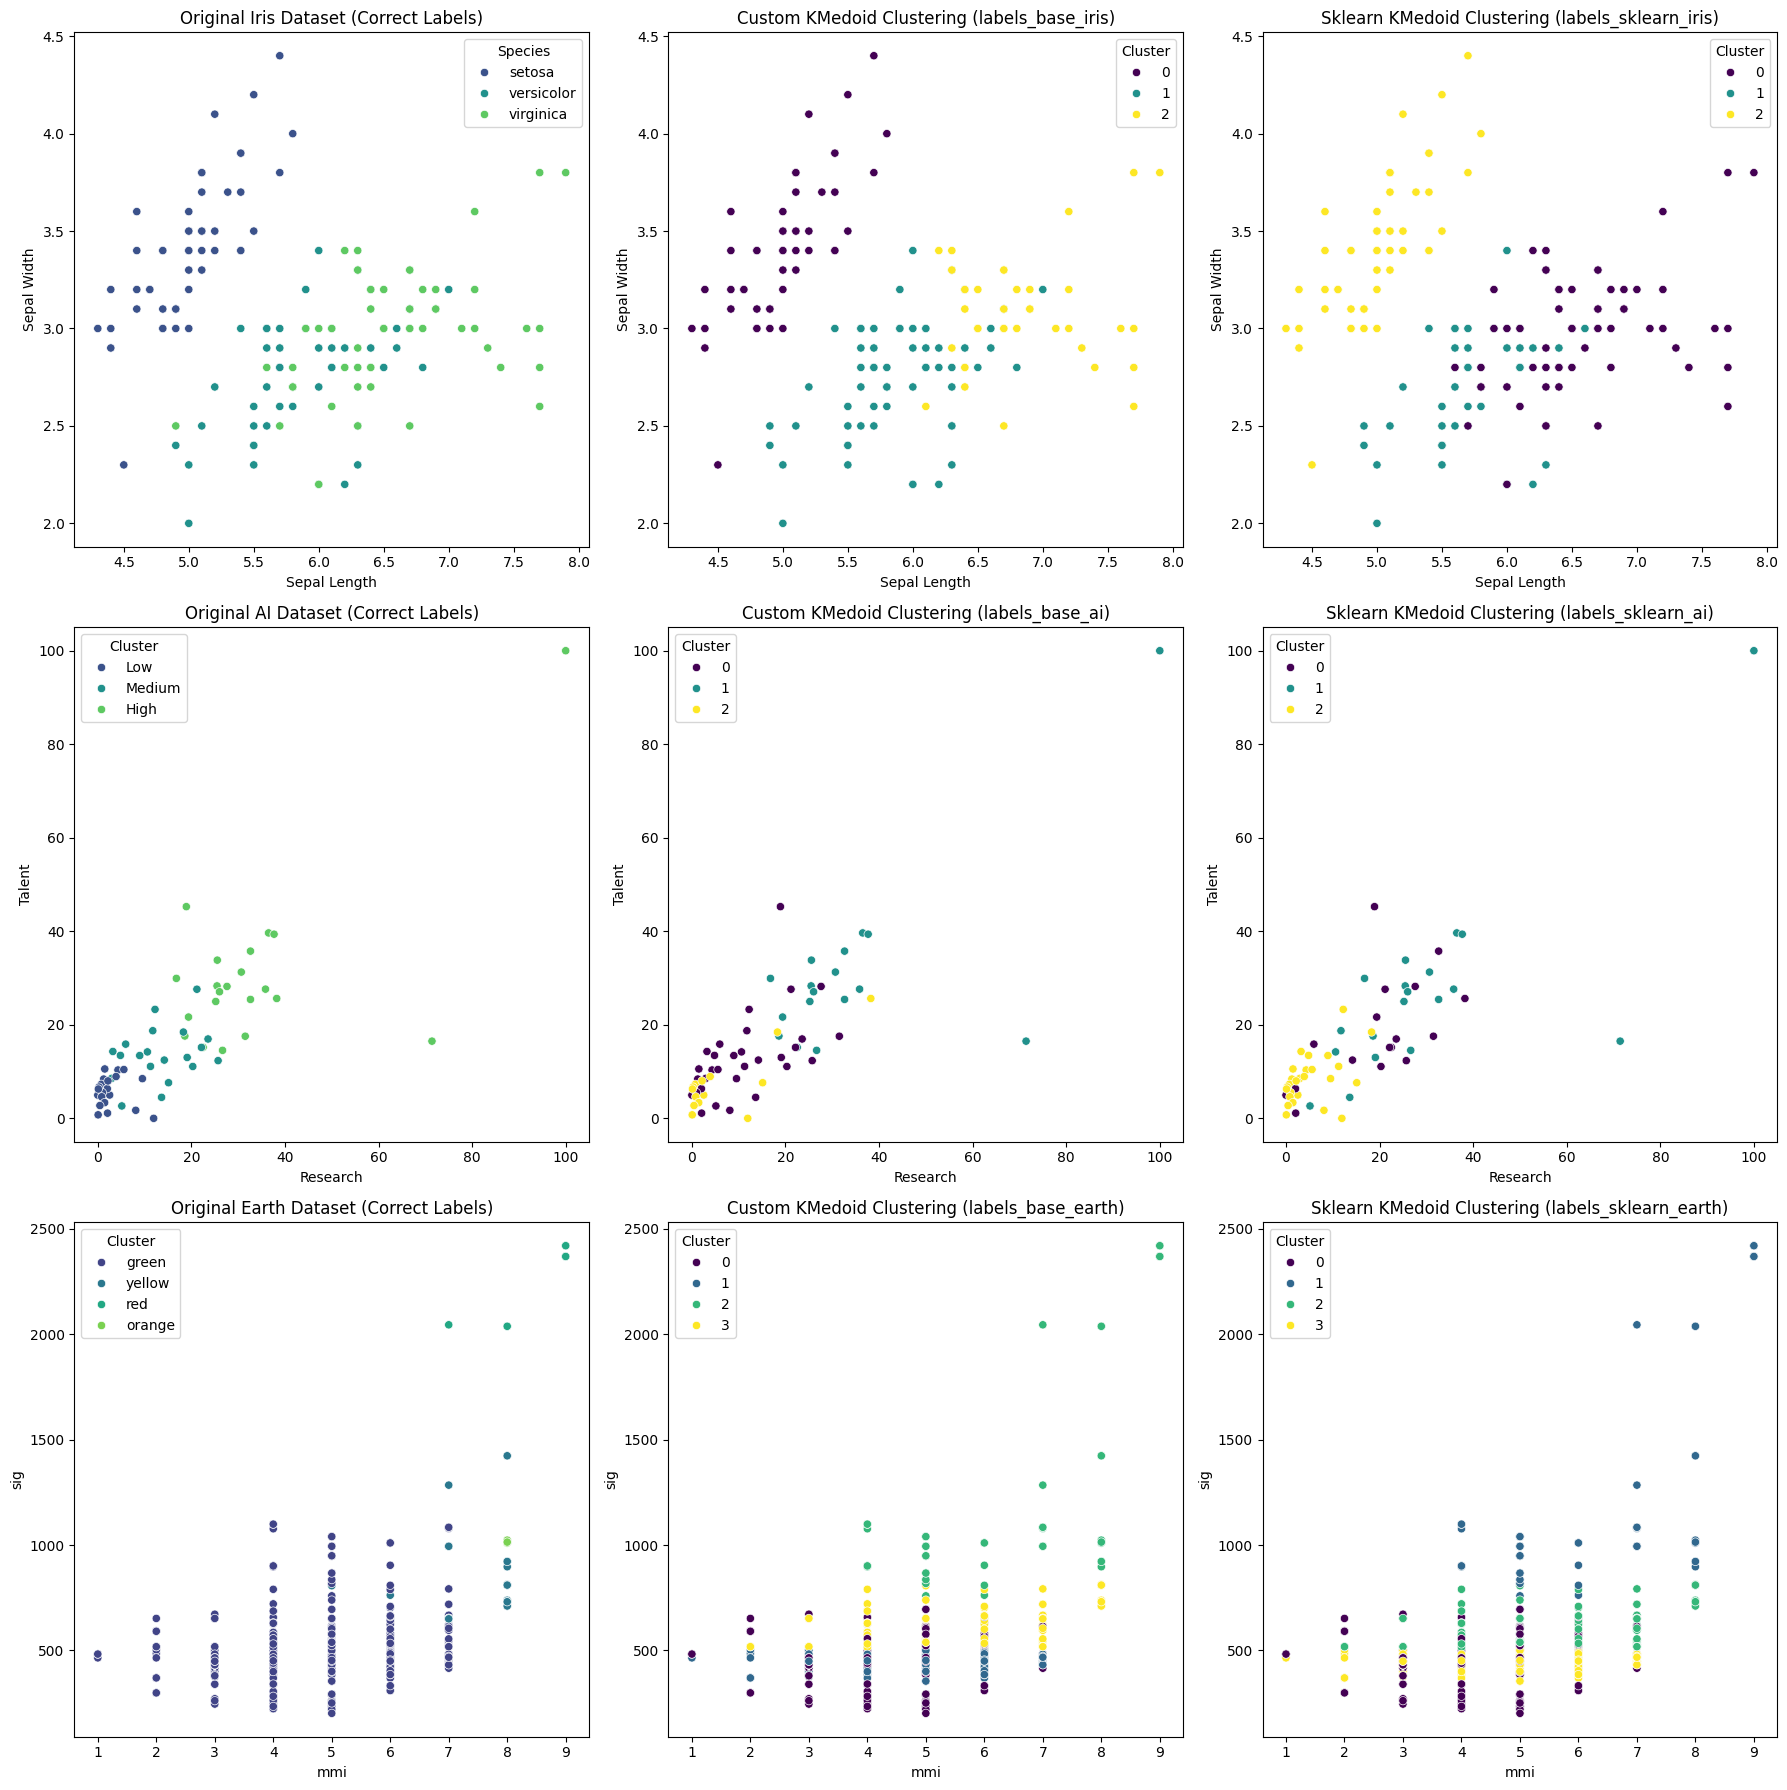

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("Sepal Length")
axes[0][0].set_ylabel("Sepal Width")
axes[0][0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[0][1])
axes[0][1].set_title("Custom KMedoid Clustering (labels_base_iris)")
axes[0][1].set_xlabel("Sepal Length")
axes[0][1].set_ylabel("Sepal Width")
axes[0][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[0][2])
axes[0][2].set_title("Sklearn KMedoid Clustering (labels_sklearn_iris)")
axes[0][2].set_xlabel("Sepal Length")
axes[0][2].set_ylabel("Sepal Width")
axes[0][2].legend(title="Cluster")

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset (Correct Labels)")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1][1])
axes[1][1].set_title("Custom KMedoid Clustering (labels_base_ai)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[1][2])
axes[1][2].set_title("Sklearn KMedoid Clustering (labels_sklearn_ai)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")


# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette="viridis", ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("sig")
axes[2][0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette="viridis", ax=axes[2][1])
axes[2][1].set_title("Custom KMedoid Clustering (labels_base_earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("sig")
axes[2][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette="viridis", ax=axes[2][2])
axes[2][2].set_title("Sklearn KMedoid Clustering (labels_sklearn_earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("sig")
axes[2][2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()